# Naive Bayes Classifier

In [1]:
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pylab as plt

import dmba
from dmba import classificationSummary, gainsChart

%matplotlib inline


no display found. Using non-interactive Agg backend


### Load flights data

In [15]:
delays_df = dmba.load_data('FlightDelays.csv')
delays_df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


## Data Pre-Processing

### convert to categorical

In [3]:

delays_df['DAY_WEEK'] = delays_df['DAY_WEEK'].astype('category')
delays_df['Flight Status'] = delays_df['Flight Status'].astype('category')


### create hourly bins departure time 

In [4]:
delays_df.CRS_DEP_TIME = [round(t / 100) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype('category')


### select predictors

In [5]:
predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER']
outcome = 'Flight Status'


### Create data partition

In [6]:
X = pd.get_dummies(delays_df[predictors])
y = delays_df['Flight Status']
classes = list(y.cat.categories)

# split into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=1)


## Run Naive Bayes

In [7]:
delays_nb = MultinomialNB(alpha=0.01)
delays_nb.fit(X_train, y_train)

MultinomialNB(alpha=0.01)

### Predict probabilities and class memberships

In [8]:

# predict probabilities
predProb_train = delays_nb.predict_proba(X_train)
predProb_valid = delays_nb.predict_proba(X_valid)

# predict class membership
y_valid_pred = delays_nb.predict(X_valid)
y_train_pred = delays_nb.predict(X_train)


### Generate posterior probabilities 

In [9]:
# split the original data frame into a train and test using the same random_state
train_df, valid_df = train_test_split(delays_df, test_size=0.4, random_state=1)

pd.set_option('display.precision', 4)
# probability of flight status
print(train_df['Flight Status'].value_counts() / len(train_df))
print()

for predictor in predictors:
    # construct the frequency table
    df = train_df[['Flight Status', predictor]]
    freqTable = df.pivot_table(index='Flight Status', columns=predictor, aggfunc=len)

    # divide each row by the sum of the row to get conditional probabilities
    propTable = freqTable.apply(lambda x: x / sum(x), axis=1)
    print(propTable)
    print()
pd.reset_option('display.precision')

Flight Status
ontime     0.8023
delayed    0.1977
Name: count, dtype: float64

DAY_WEEK            1       2       3       4       5      6       7
Flight Status                                                       
delayed        0.1916  0.1494  0.1149  0.1264  0.1877  0.069  0.1609
ontime         0.1246  0.1416  0.1445  0.1794  0.1690  0.136  0.1048

CRS_DEP_TIME        6       7       8       9      10      11      12      13  \
Flight Status                                                                   
delayed        0.0345  0.0536  0.0651  0.0192  0.0307  0.0115  0.0498  0.0460   
ontime         0.0623  0.0633  0.0850  0.0567  0.0519  0.0340  0.0661  0.0746   

CRS_DEP_TIME       14      15      16      17      18      19      20      21  
Flight Status                                                                  
delayed        0.0383  0.2031  0.0728  0.1533  0.0192  0.0996  0.0153  0.0881  
ontime         0.0576  0.1171  0.0774  0.1001  0.0349  0.0397  0.0264  0.0529  

/var/folders/w5/jf80gl6n4n93r9zzwvmjj1w40000gn/T/ipykernel_59530/1770188515.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  freqTable = df.pivot_table(index='Flight Status', columns=predictor, aggfunc=len)
/var/folders/w5/jf80gl6n4n93r9zzwvmjj1w40000gn/T/ipykernel_59530/1770188515.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  freqTable = df.pivot_table(index='Flight Status', columns=predictor, aggfunc=len)
/var/folders/w5/jf80gl6n4n93r9zzwvmjj1w40000gn/T/ipykernel_59530/1770188515.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this

In [10]:
# P(delayed | Carrier = DL, Day_Week = 7, Dep_Time = 10, Dest = LGA, Origin = DCA)
P_hat_delayed = 0.0958 * 0.1609 * 0.0307 * 0.4215 * 0.5211 * 0.1977
# P(ontime | Carrier = DL, Day_Week = 7, Dep_Time = 10, Dest = LGA, Origin = DCA)
P_hat_ontime = 0.2040 * 0.1048 * 0.0519 * 0.5779 * 0.6478 * 0.8023
print('P_hat_delayed ~ ', P_hat_delayed)
print('P_hat_ontime ~ ', P_hat_ontime)

print('P(delayed|...) = ', P_hat_delayed / (P_hat_delayed + P_hat_ontime))
print('P(ontime|...) = ', P_hat_ontime / (P_hat_delayed + P_hat_ontime))

P_hat_delayed ~  2.0548742506526157e-05
P_hat_ontime ~  0.00033326464123921066
P(delayed|...) =  0.05807791183301656
P(ontime|...) =  0.9419220881669834


### Generate Confusion Matrix

In [11]:
classificationSummary(y_train, y_train_pred, class_names=classes) 

print()

classificationSummary(y_valid, y_valid_pred, class_names=classes) 

Confusion Matrix (Accuracy 0.7955)

        Prediction
 Actual delayed  ontime
delayed      52     209
 ontime      61     998

Confusion Matrix (Accuracy 0.7821)

        Prediction
 Actual delayed  ontime
delayed      26     141
 ontime      51     663


### Generate Gains chart

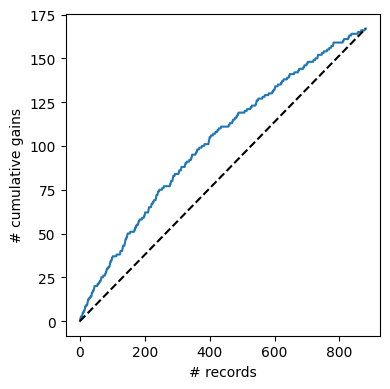

In [12]:
df = pd.DataFrame({'actual': 1 - y_valid.cat.codes, 'prob': predProb_valid[:, 0]})
df = df.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

fig, ax = plt.subplots()
fig.set_size_inches(4, 4)
gainsChart(df.actual, ax=ax)

plt.tight_layout()
plt.show()